In [1]:
import xarray as xr
import pandas as pd
import numpy as np
import calendar as cld
import matplotlib.pyplot as plt
import matplotlib.colors
colors_land = plt.cm.terrain(np.linspace(0.25, 1, 256))
import proplot as pplt # New plot library (https://proplot.readthedocs.io/en/latest/)
pplt.rc['savefig.dpi'] = 300 # 1200 is too big! #https://proplot.readthedocs.io/en/latest/basics.html#Creating-figures
from scipy.stats import chi2
from numba import njit,prange
import matplotlib as mpl
mpl.rcParams['hatch.linewidth'] = 0.05  # previous pdf hatch linewidth
from matplotlib.dates import DateFormatter

from scipy.stats import linregress

In [2]:
normal_format = {'gridlinewidth':0.1, 'gridcolor':'gray8', 'gridalpha':0.5, 'coast':True,'borders':True ,'reso':'hi', 'labels':True, 'lonlines':2, 'latlines':2, 'abc':False, 'latlim':[43.,48.5],'lonlim':[4.,16.]}
multiplot_format = {'gridlinewidth':0.1, 'gridcolor':'gray8', 'gridalpha':0.5, 'coast':True,'borders':True ,'reso':'hi', 'labels':False, 'lonlines':2, 'latlines':2, 'abc':False, 'latlim':[43.,48.5],'lonlim':[4.,16.]}

imin = 32 ; imax = -30
jmin = 20 ; jmax = -15
ds = xr.open_dataset('/bettik/beaumetj/MARout/MAR-ERA-20C/MARgrid_EUf.nc')
lon = ds.LON[jmin:jmax,imin:imax]
lat = ds.LAT[jmin:jmax,imin:imax]
H = np.array(ds.SH[jmin:jmax,imin:imax])

In [3]:
wp_meanseason_meanT = np.load('/bettik/castelli/data/saved_data_MAR_ECEarth3/wp_meanseason_meanT.npy')[:,:,jmin:jmax,imin:imax]

wp_meanseason_meanT_hist = wp_meanseason_meanT[:54,:,:,:]
wp_meanseason_meanT_fut = wp_meanseason_meanT[55:,:,:,:]

origin_T_hist=np.full(wp_meanseason_meanT_hist.shape[1:4],np.nan)
slope_T_hist=np.full(wp_meanseason_meanT_hist.shape[1:4],np.nan)
pvalue_T_hist=np.full(wp_meanseason_meanT_hist.shape[1:4],np.nan)

origin_T_fut=np.full(wp_meanseason_meanT_fut.shape[1:4],np.nan)
slope_T_fut=np.full(wp_meanseason_meanT_fut.shape[1:4],np.nan)
pvalue_T_fut=np.full(wp_meanseason_meanT_fut.shape[1:4],np.nan)

for i in range(wp_meanseason_meanT.shape[3]):
    # print(str(lon)+'/'+str(les_season_maxT.shape[3]),end=' ')
    for j in range(wp_meanseason_meanT.shape[2]):
        for season in range(4):
            linregress_T_hist = linregress(np.arange(wp_meanseason_meanT_hist.shape[0]), wp_meanseason_meanT_hist[:,season,j,i])
            origin_T_hist[season][j][i] = linregress_T_hist.intercept
            slope_T_hist[season][j][i] = linregress_T_hist.slope
            pvalue_T_hist[season][j][i] = linregress_T_hist.pvalue
            
            linregress_T_fut = linregress(np.arange(wp_meanseason_meanT_fut.shape[0]), wp_meanseason_meanT_fut[:,season,j,i])
            origin_T_fut[season][j][i] = linregress_T_fut.intercept
            slope_T_fut[season][j][i] = linregress_T_fut.slope
            pvalue_T_fut[season][j][i] = linregress_T_fut.pvalue

In [4]:
def detect_alps(H):
    nlat,nlon = np.shape(H)
    mask = np.bool8(np.zeros((nlat,nlon)))
    r = 4
    for j in range(r,nlat-r):
        for i in range(r,nlon-r):
            mask[j,i] = np.logical_and(H[j,i]>360 ,np.any(H[j-r:j+r,i-r:i+r]>1300))
            # mask[j,i] = np.std(H[j-r:j+r,i-r:i+r])>200
    return mask
alps = detect_alps(H)
alps[lon<4.8] = False
alps[np.logical_and(lon>10,lat<45.2)] = False

north_alps = np.copy(alps)
north_alps[lon>8.6] = False
north_alps[lat<45] = False
#north_alps[lat>46.5] = False

south_alps = np.copy(alps)
south_alps[lat>45] = False

east_alps = np.copy(alps)
east_alps[lon<8.6] = False

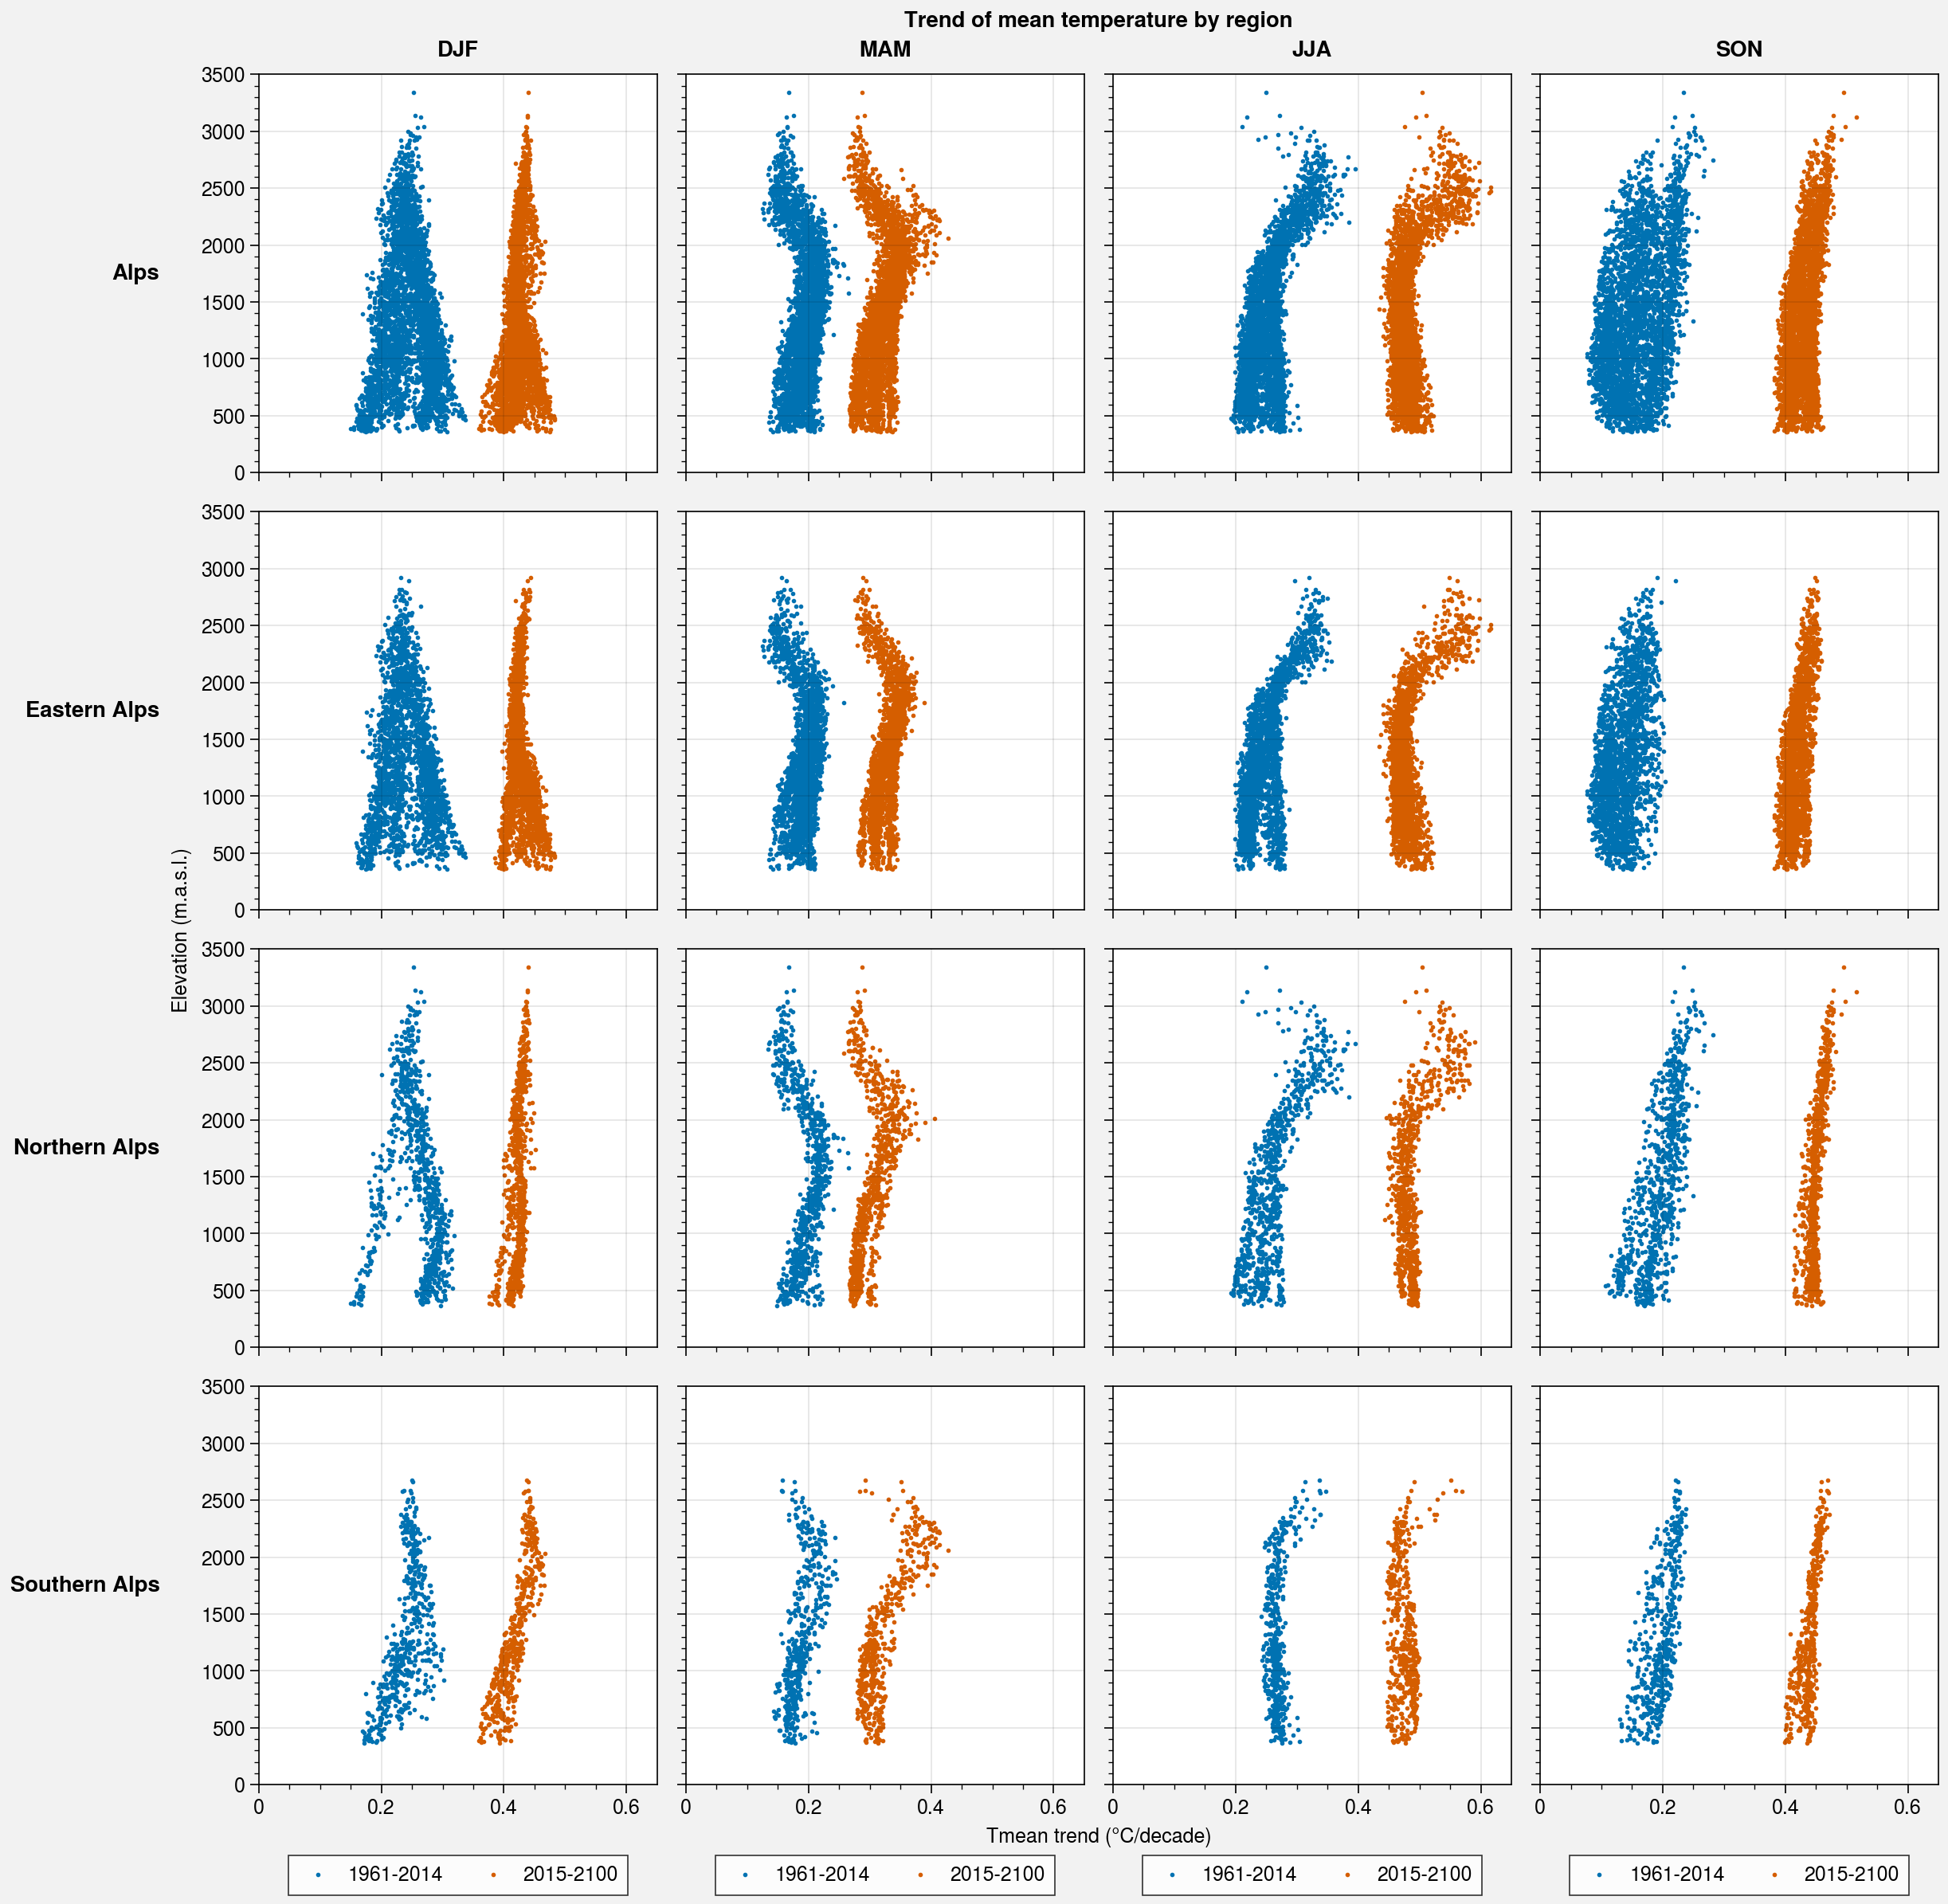

In [5]:
f, axs = pplt.subplots(ncols=4, nrows=4)
leg = ['1961-2014','2015-2100']

for i in range(4):
    slope_T_hist_alps = np.ma.masked_array(slope_T_hist[i], mask=np.invert(alps))
    slope_T_hist_east_alps = np.ma.masked_array(slope_T_hist[i], mask=np.invert(east_alps))
    slope_T_hist_north_alps = np.ma.masked_array(slope_T_hist[i], mask=np.invert(north_alps))
    slope_T_hist_south_alps = np.ma.masked_array(slope_T_hist[i], mask=np.invert(south_alps))
    slopes=[slope_T_hist_alps,slope_T_hist_east_alps,slope_T_hist_north_alps,slope_T_hist_south_alps]
    
    for j,slope in enumerate(slopes):
        ax = axs[i+4*j]
        blue_dot = ax.scatter(10*slope,ds.SH[jmin:jmax,imin:imax],s=2)
        
    
for i in range(4):
    slope_T_fut_alps = np.ma.masked_array(slope_T_fut[i], mask=np.invert(alps))
    slope_T_fut_east_alps = np.ma.masked_array(slope_T_fut[i], mask=np.invert(east_alps))
    slope_T_fut_north_alps = np.ma.masked_array(slope_T_fut[i], mask=np.invert(north_alps))
    slope_T_fut_south_alps = np.ma.masked_array(slope_T_fut[i], mask=np.invert(south_alps))
    slopes=[slope_T_fut_alps,slope_T_fut_east_alps,slope_T_fut_north_alps,slope_T_fut_south_alps]
    
    for j,slope in enumerate(slopes):
        ax = axs[i+4*j]
        orange_dot = ax.scatter(10*slope,ds.SH[jmin:jmax,imin:imax],s=2)
        ax.set_xlim((0.,0.65))
        ax.set_ylim((0.,3500))
        if(j==3):
            ax.legend([blue_dot,orange_dot],leg,loc='bottom')

axs.format(suptitle='Trend of mean temperature by region',collabels=['DJF','MAM','JJA', 'SON'],
           rowlabels=['Alps','Eastern Alps','Northern Alps','Southern Alps'],xlabel='Tmean trend (°C/decade)',ylabel='Elevation (m.a.s.l.)')

#### Spring, future period, entire Alps

(0.0, 3500.0)

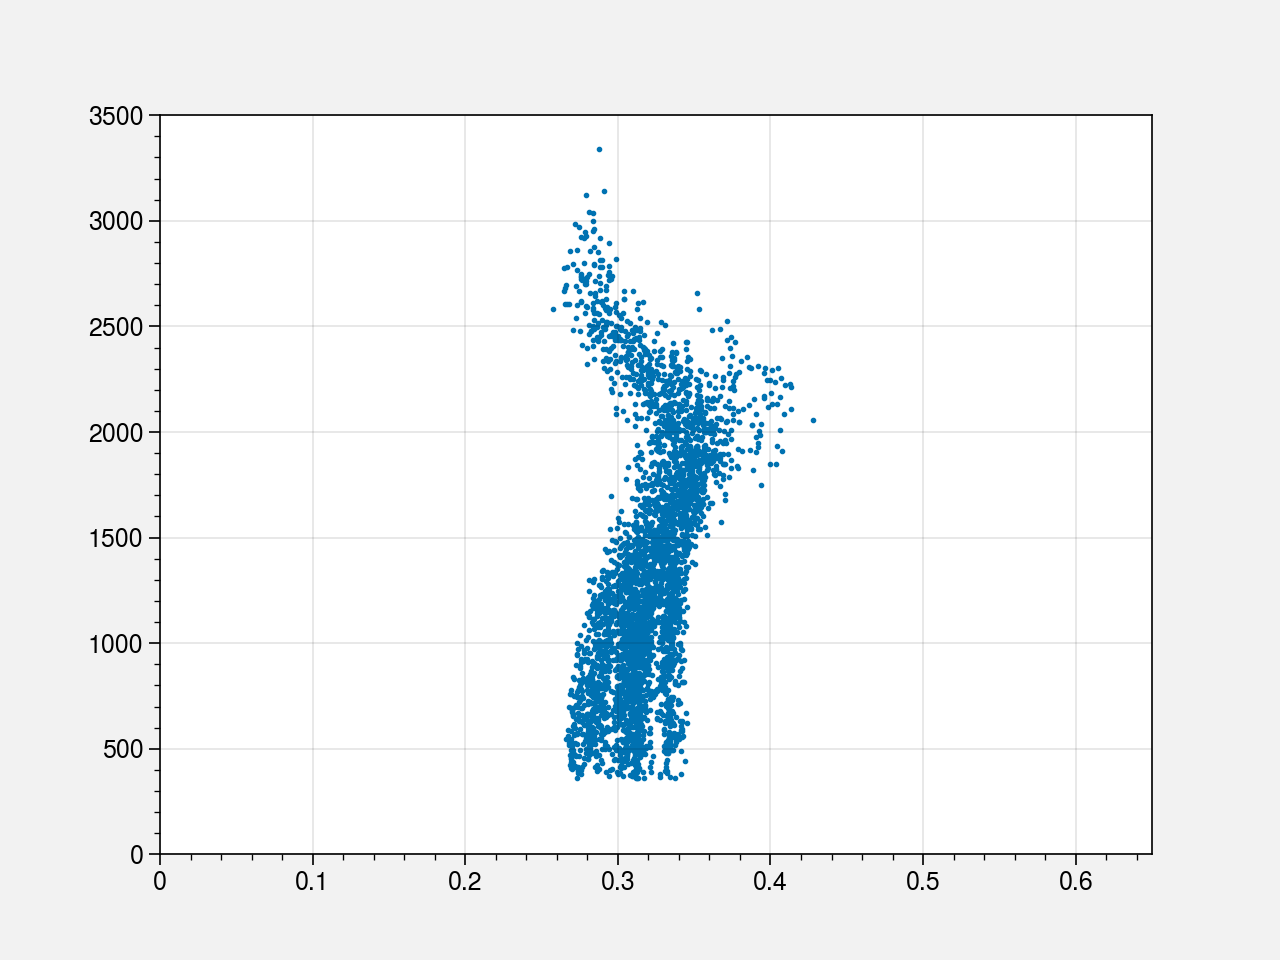

In [7]:
slope_T_MAM_fut_alps = 10*np.ma.masked_array(slope_T_fut[1], mask=np.invert(alps))
height = np.ma.masked_array(ds.SH[jmin:jmax,imin:imax], mask=np.invert(alps))

plt.scatter(slope_T_MAM_fut_alps,height,s=2)
plt.xlim((0.,0.65))
plt.ylim((0.,3500))

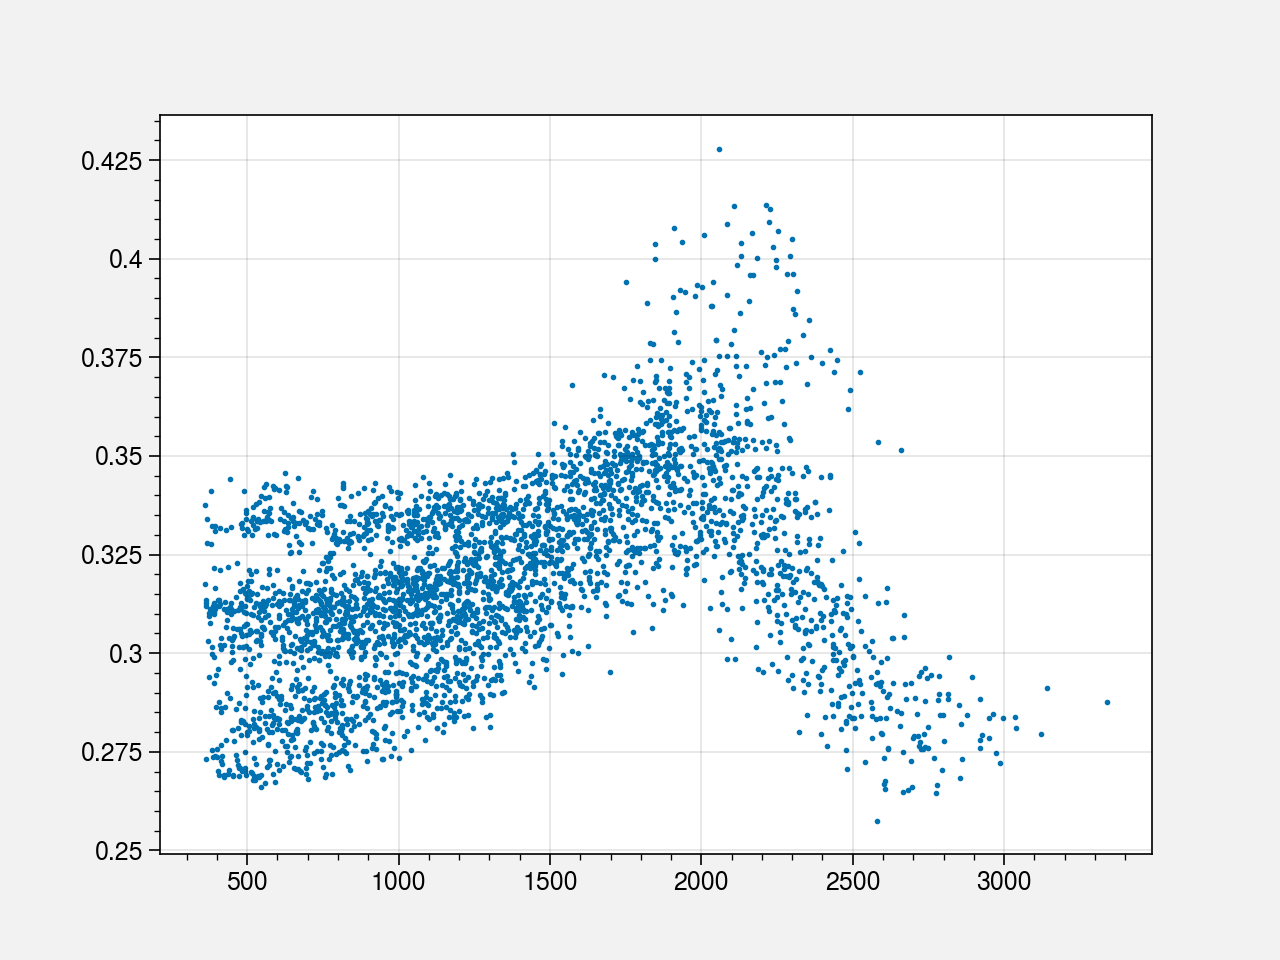

In [7]:
plt.scatter(height,slope_T_MAM_fut_alps,s=2)

In [8]:
from scipy import interpolate

vec_slope_T_MAM_fut_alps = slope_T_MAM_fut_alps[slope_T_MAM_fut_alps.mask == False]
vec_height = height[height.mask == False]

vec_slope_T_MAM_fut_alps_srt = [x for (y,x) in sorted(zip(vec_height,vec_slope_T_MAM_fut_alps), key=lambda pair: pair[0])]
vec_height_srt = [y for (y,x) in sorted(zip(vec_height,vec_slope_T_MAM_fut_alps), key=lambda pair: pair[0])]


In [9]:
def spline(knots, x, y):
    x_new = np.linspace(0, 1, knots+2)[1:-1]
    q_knots = np.quantile(x, x_new)
    t, c, k = interpolate.splrep(x, y, t=q_knots)
    yfit = interpolate.BSpline(t,c, k)(x)
    return yfit

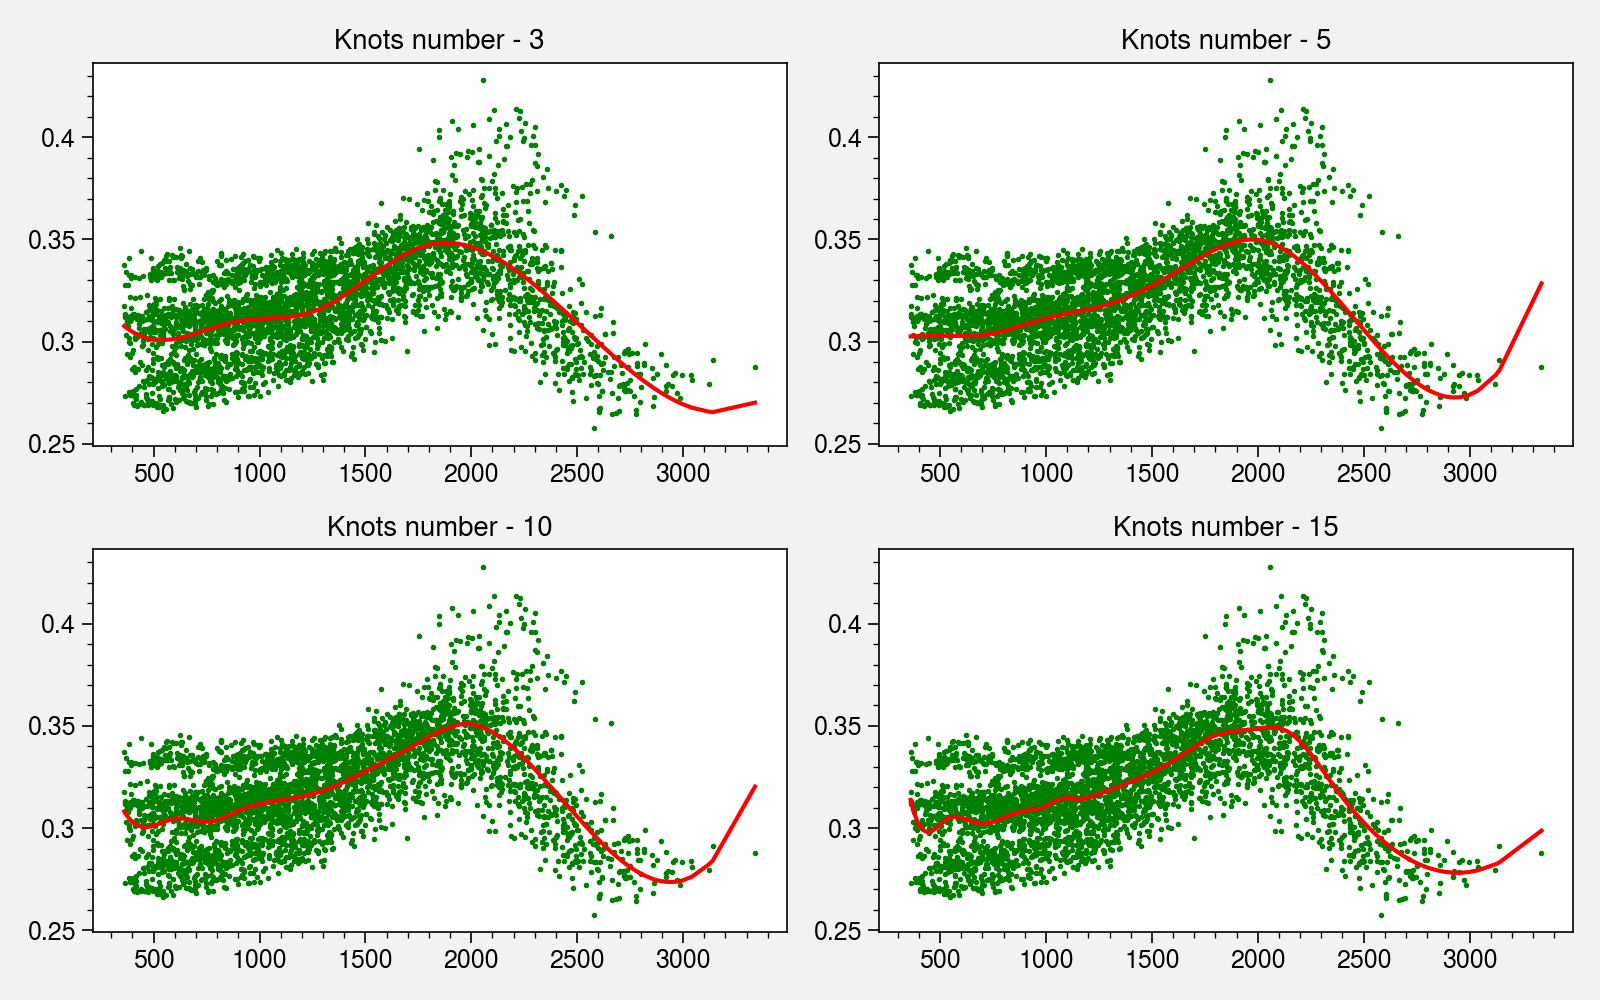

In [10]:
knots = [3, 5, 10, 15]
i = 0

ig, ax = plt.subplots(nrows=2, ncols=2, figsize=(8, 5))

 

for row in range(2):
    for col in range(2):
        ax[row][col].plot(vec_height_srt, vec_slope_T_MAM_fut_alps_srt, '.',c="g", markersize=2)
        yfit = spline(knots[i],vec_height_srt, vec_slope_T_MAM_fut_alps_srt)
        ax[row][col].plot(vec_height_srt, yfit, 'r')
        ax[row][col].set_title("Knots number - "+str(knots[i]))
        ax[row][col].grid()
        i=i+1
        
plt.tight_layout()        
plt.show() 

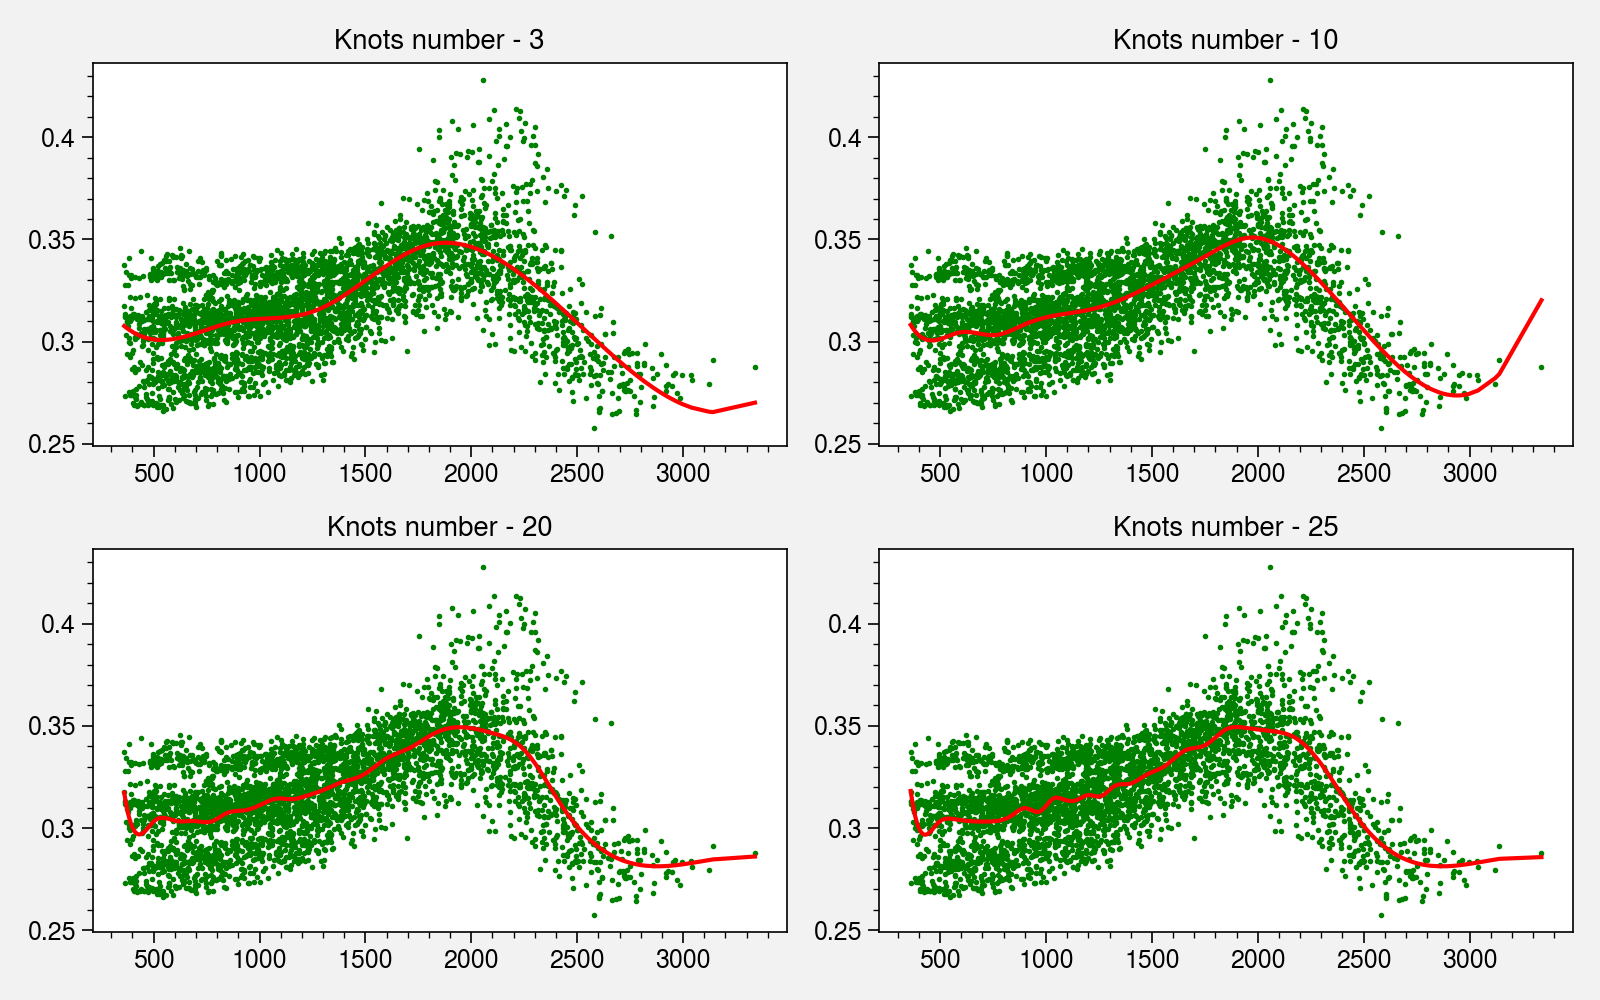

In [64]:
knots = [3, 10, 20, 25]
i = 0

ig, ax = plt.subplots(nrows=2, ncols=2, figsize=(8, 5))

 

for row in range(2):
    for col in range(2):
        ax[row][col].plot(vec_height_srt, vec_slope_T_MAM_fut_alps_srt, '.',c="g", markersize=2)
        yfit = spline(knots[i],vec_height_srt, vec_slope_T_MAM_fut_alps_srt)
        ax[row][col].plot(vec_height_srt, yfit, 'r')
        ax[row][col].set_title("Knots number - "+str(knots[i]))
        ax[row][col].grid()
        i=i+1
        
plt.tight_layout()        
plt.show() 

In [10]:
knot_numbers = 3
height_new = np.linspace(0, 1, knot_numbers+2)[1:-1]
q_knots = np.quantile(vec_height_srt, height_new)

t,c,k = interpolate.splrep(vec_height_srt, vec_slope_T_MAM_fut_alps_srt, t=q_knots, s=1)
yfit = interpolate.BSpline(t,c,k)(vec_height_srt)

In [11]:
vec_height_srt[np.argmax(yfit)]

1879.068

In [12]:
knot_numbers = 10
height_new = np.linspace(0, 1, knot_numbers+2)[1:-1]
q_knots = np.quantile(vec_height_srt, height_new)

t,c,k = interpolate.splrep(vec_height_srt, vec_slope_T_MAM_fut_alps_srt, t=q_knots, s=1)
yfit = interpolate.BSpline(t,c,k)(vec_height_srt)

In [13]:
vec_height_srt[np.argmax(yfit)]

1976.5571

#### Summer, future period, entire alps

(0.0, 3500.0)

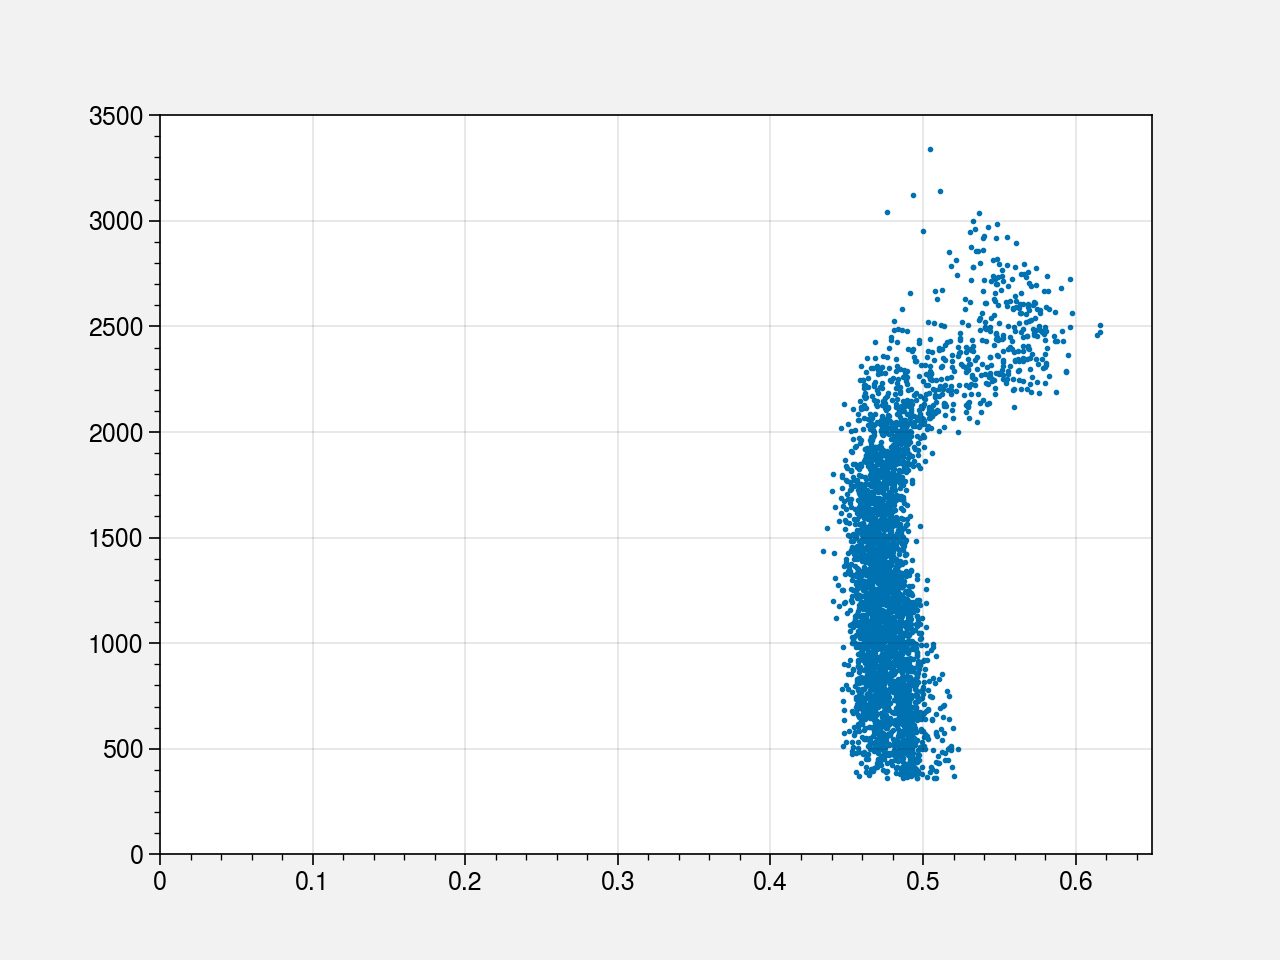

In [11]:
slope_T_JJA_fut_alps = 10*np.ma.masked_array(slope_T_fut[2], mask=np.invert(alps))
height = np.ma.masked_array(ds.SH[jmin:jmax,imin:imax], mask=np.invert(alps))

plt.scatter(slope_T_JJA_fut_alps,height,s=2)
plt.xlim((0.,0.65))
plt.ylim((0.,3500))

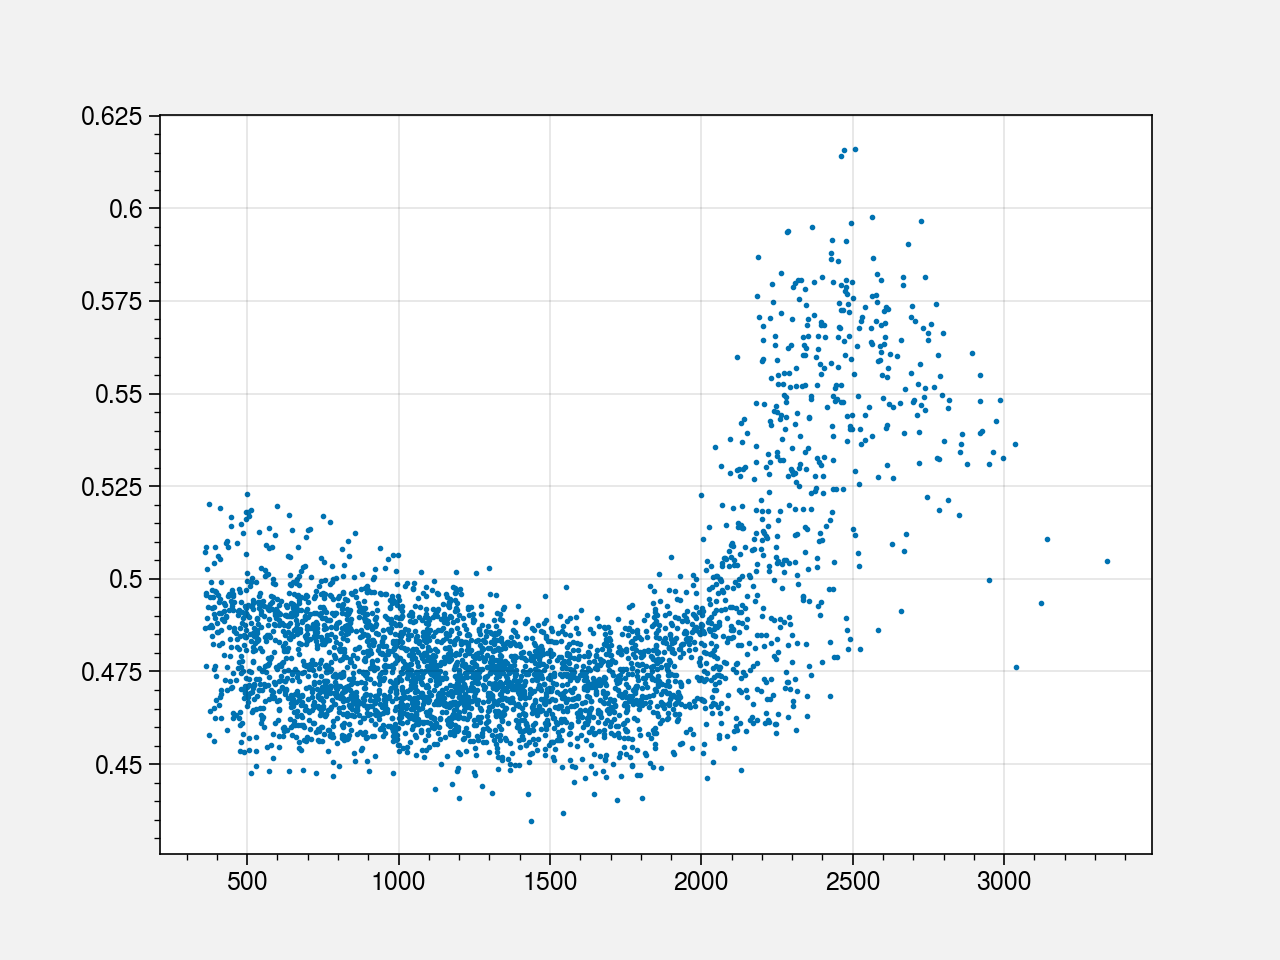

In [12]:
plt.scatter(height,slope_T_JJA_fut_alps,s=2)

In [13]:
vec_slope_T_JJA_fut_alps = slope_T_JJA_fut_alps[slope_T_JJA_fut_alps.mask == False]


vec_slope_T_JJA_fut_alps_srt = [x for (y,x) in sorted(zip(vec_height,vec_slope_T_JJA_fut_alps), key=lambda pair: pair[0])]
vec_height_srt = [y for (y,x) in sorted(zip(vec_height,vec_slope_T_MAM_fut_alps), key=lambda pair: pair[0])]

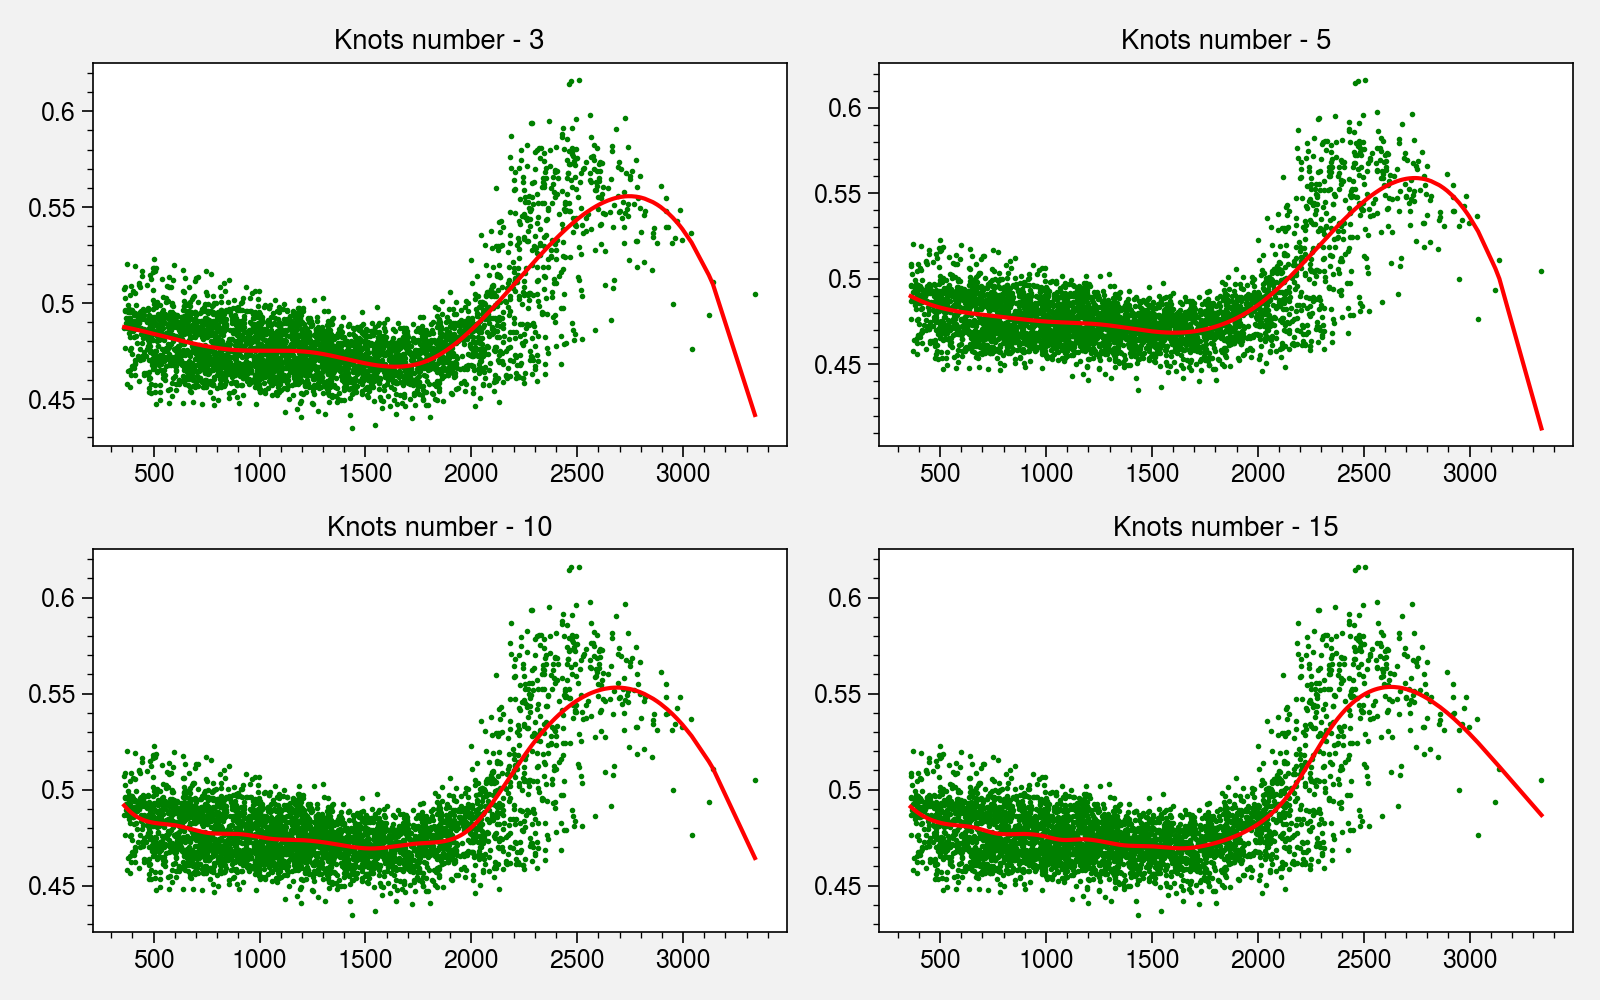

In [14]:
knots = [3, 5, 10, 15]
i = 0

ig, ax = plt.subplots(nrows=2, ncols=2, figsize=(8, 5))

 

for row in range(2):
    for col in range(2):
        ax[row][col].plot(vec_height_srt, vec_slope_T_JJA_fut_alps_srt, '.',c="g", markersize=2)
        yfit = spline(knots[i],vec_height_srt, vec_slope_T_JJA_fut_alps_srt)
        ax[row][col].plot(vec_height_srt, yfit, 'r')
        ax[row][col].set_title("Knots number - "+str(knots[i]))
        ax[row][col].grid()
        i=i+1
        
plt.tight_layout()        
plt.show() 

### Evolution of peak of warming

In [11]:
wp_meanseason_meanT_hist.shape[1:4]

(4, 91, 139)

In [28]:

slope_T_periods_50=np.full((90, 4, 91, 139),np.nan)

firstperiod_start = 1961
lastperiod_start = 2051

for year in np.arange(0,90):
    print(year,end=' ')
    endyear = year+50
    wp_meanseason_meanT_period = wp_meanseason_meanT[year:endyear,:,:,:]
    for i in range(wp_meanseason_meanT.shape[3]):
        # print(str(lon)+'/'+str(les_season_maxT.shape[3]),end=' ')
        for j in range(wp_meanseason_meanT.shape[2]):
            for season in range(4):
                linregress_T_hist = linregress(np.arange(wp_meanseason_meanT_period.shape[0]), wp_meanseason_meanT_period[:,season,j,i])
                slope_T_periods_50[year][season][j][i] = linregress_T_hist.slope


0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 

In [22]:
np.save('/bettik/castelli/data/saved_data_MAR_ECEarth3/slope_T_30yearperiods.npy', slope_T_periods)

In [29]:
np.save('/bettik/castelli/data/saved_data_MAR_ECEarth3/slope_T_50yearperiods.npy', slope_T_periods_50)

In [12]:
slope_T_periods_50 = np.load('/bettik/castelli/data/saved_data_MAR_ECEarth3/slope_T_50yearperiods.npy')

NameError: name 'slope_T_periods' is not defined

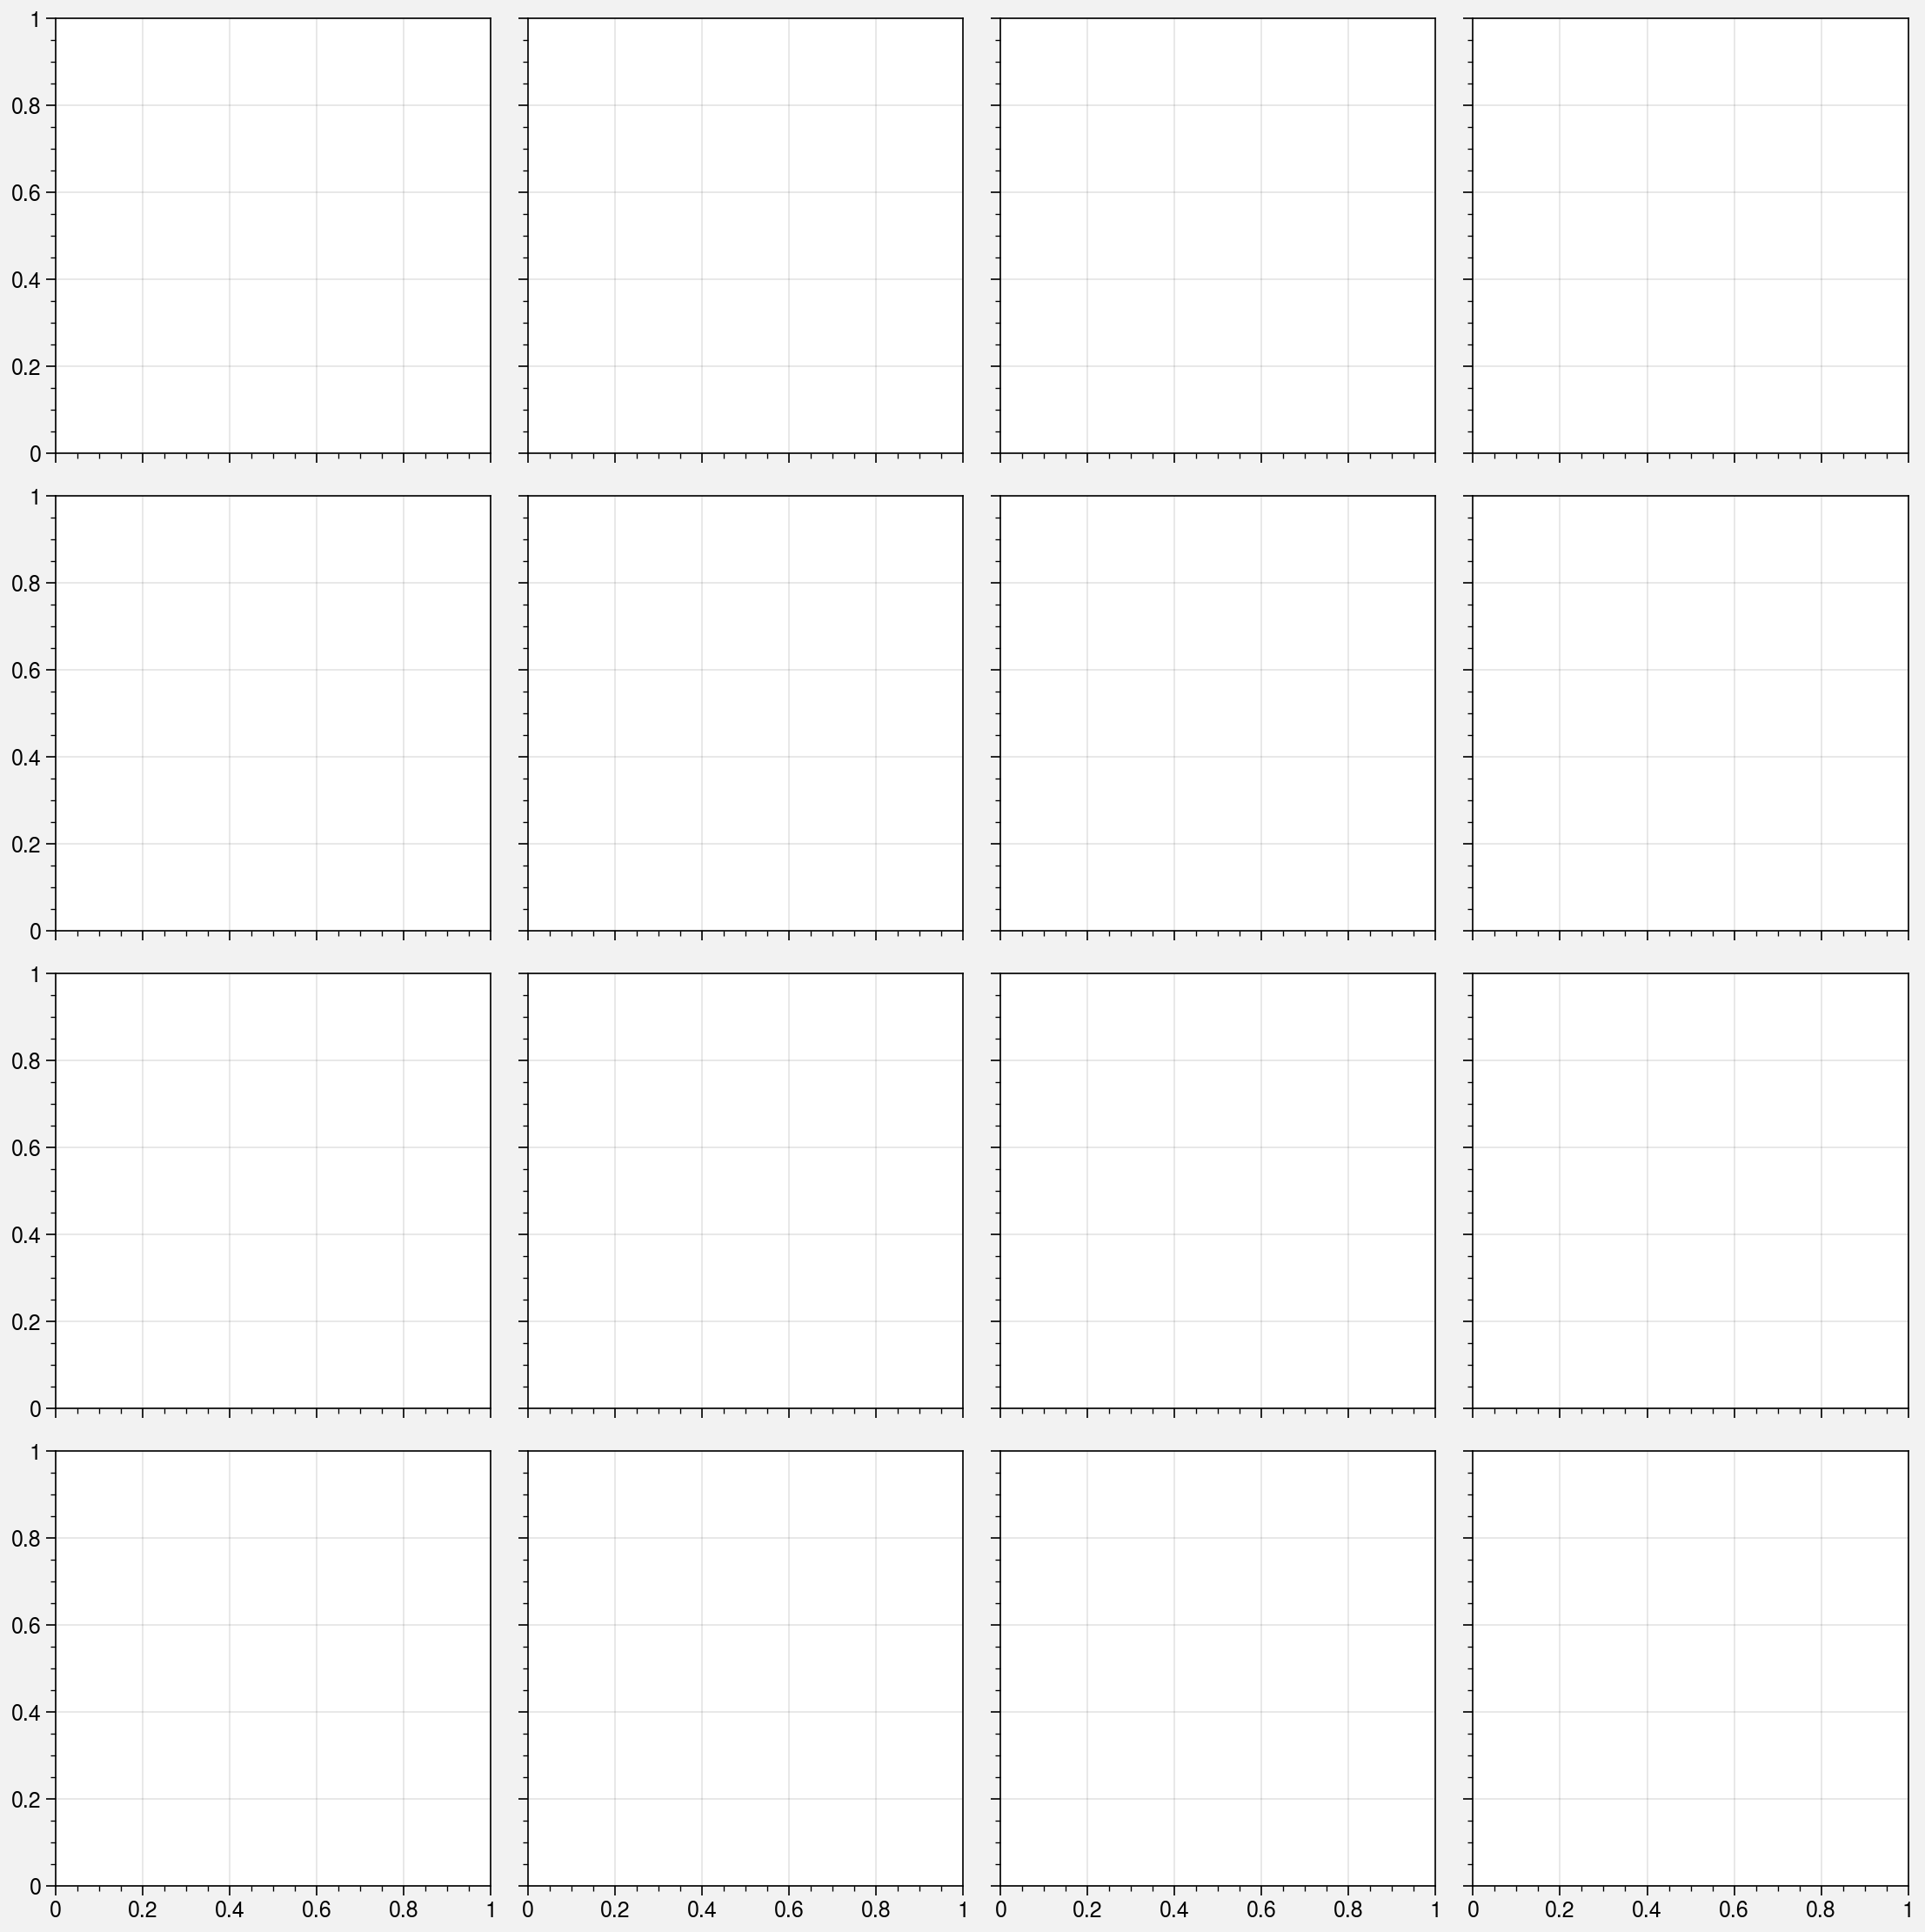

In [13]:
f, axs = pplt.subplots(ncols=4, nrows=4)
leg = ['1961-1990','2071-2100']

for i in range(4):
    slope_T_hist_alps = np.ma.masked_array(slope_T_periods[0,i], mask=np.invert(alps))
    slope_T_hist_east_alps = np.ma.masked_array(slope_T_periods[0,i], mask=np.invert(east_alps))
    slope_T_hist_north_alps = np.ma.masked_array(slope_T_periods[0,i], mask=np.invert(north_alps))
    slope_T_hist_south_alps = np.ma.masked_array(slope_T_periods[0,i], mask=np.invert(south_alps))
    slopes=[slope_T_hist_alps,slope_T_hist_east_alps,slope_T_hist_north_alps,slope_T_hist_south_alps]
    
    for j,slope in enumerate(slopes):
        ax = axs[i+4*j]
        blue_dot = ax.scatter(10*slope,ds.SH[jmin:jmax,imin:imax],s=2)
        
    
for i in range(4):
    slope_T_fut_alps = np.ma.masked_array(slope_T_periods[-1,i], mask=np.invert(alps))
    slope_T_fut_east_alps = np.ma.masked_array(slope_T_periods[-1,i], mask=np.invert(east_alps))
    slope_T_fut_north_alps = np.ma.masked_array(slope_T_periods[-1,i], mask=np.invert(north_alps))
    slope_T_fut_south_alps = np.ma.masked_array(slope_T_periods[-1,i], mask=np.invert(south_alps))
    slopes=[slope_T_fut_alps,slope_T_fut_east_alps,slope_T_fut_north_alps,slope_T_fut_south_alps]
    
    for j,slope in enumerate(slopes):
        ax = axs[i+4*j]
        orange_dot = ax.scatter(10*slope,ds.SH[jmin:jmax,imin:imax],s=2)
        ax.set_xlim((-0.3,1.1))
        ax.set_ylim((0.,3500))
        if(j==3):
            ax.legend([blue_dot,orange_dot],leg,loc='bottom')

axs.format(suptitle='Trend of mean temperature by region',collabels=['DJF','MAM','JJA', 'SON'],
           rowlabels=['Alps','Eastern Alps','Northern Alps','Southern Alps'],xlabel='Tmean trend (°C/decade)',ylabel='Elevation (m.a.s.l.)')

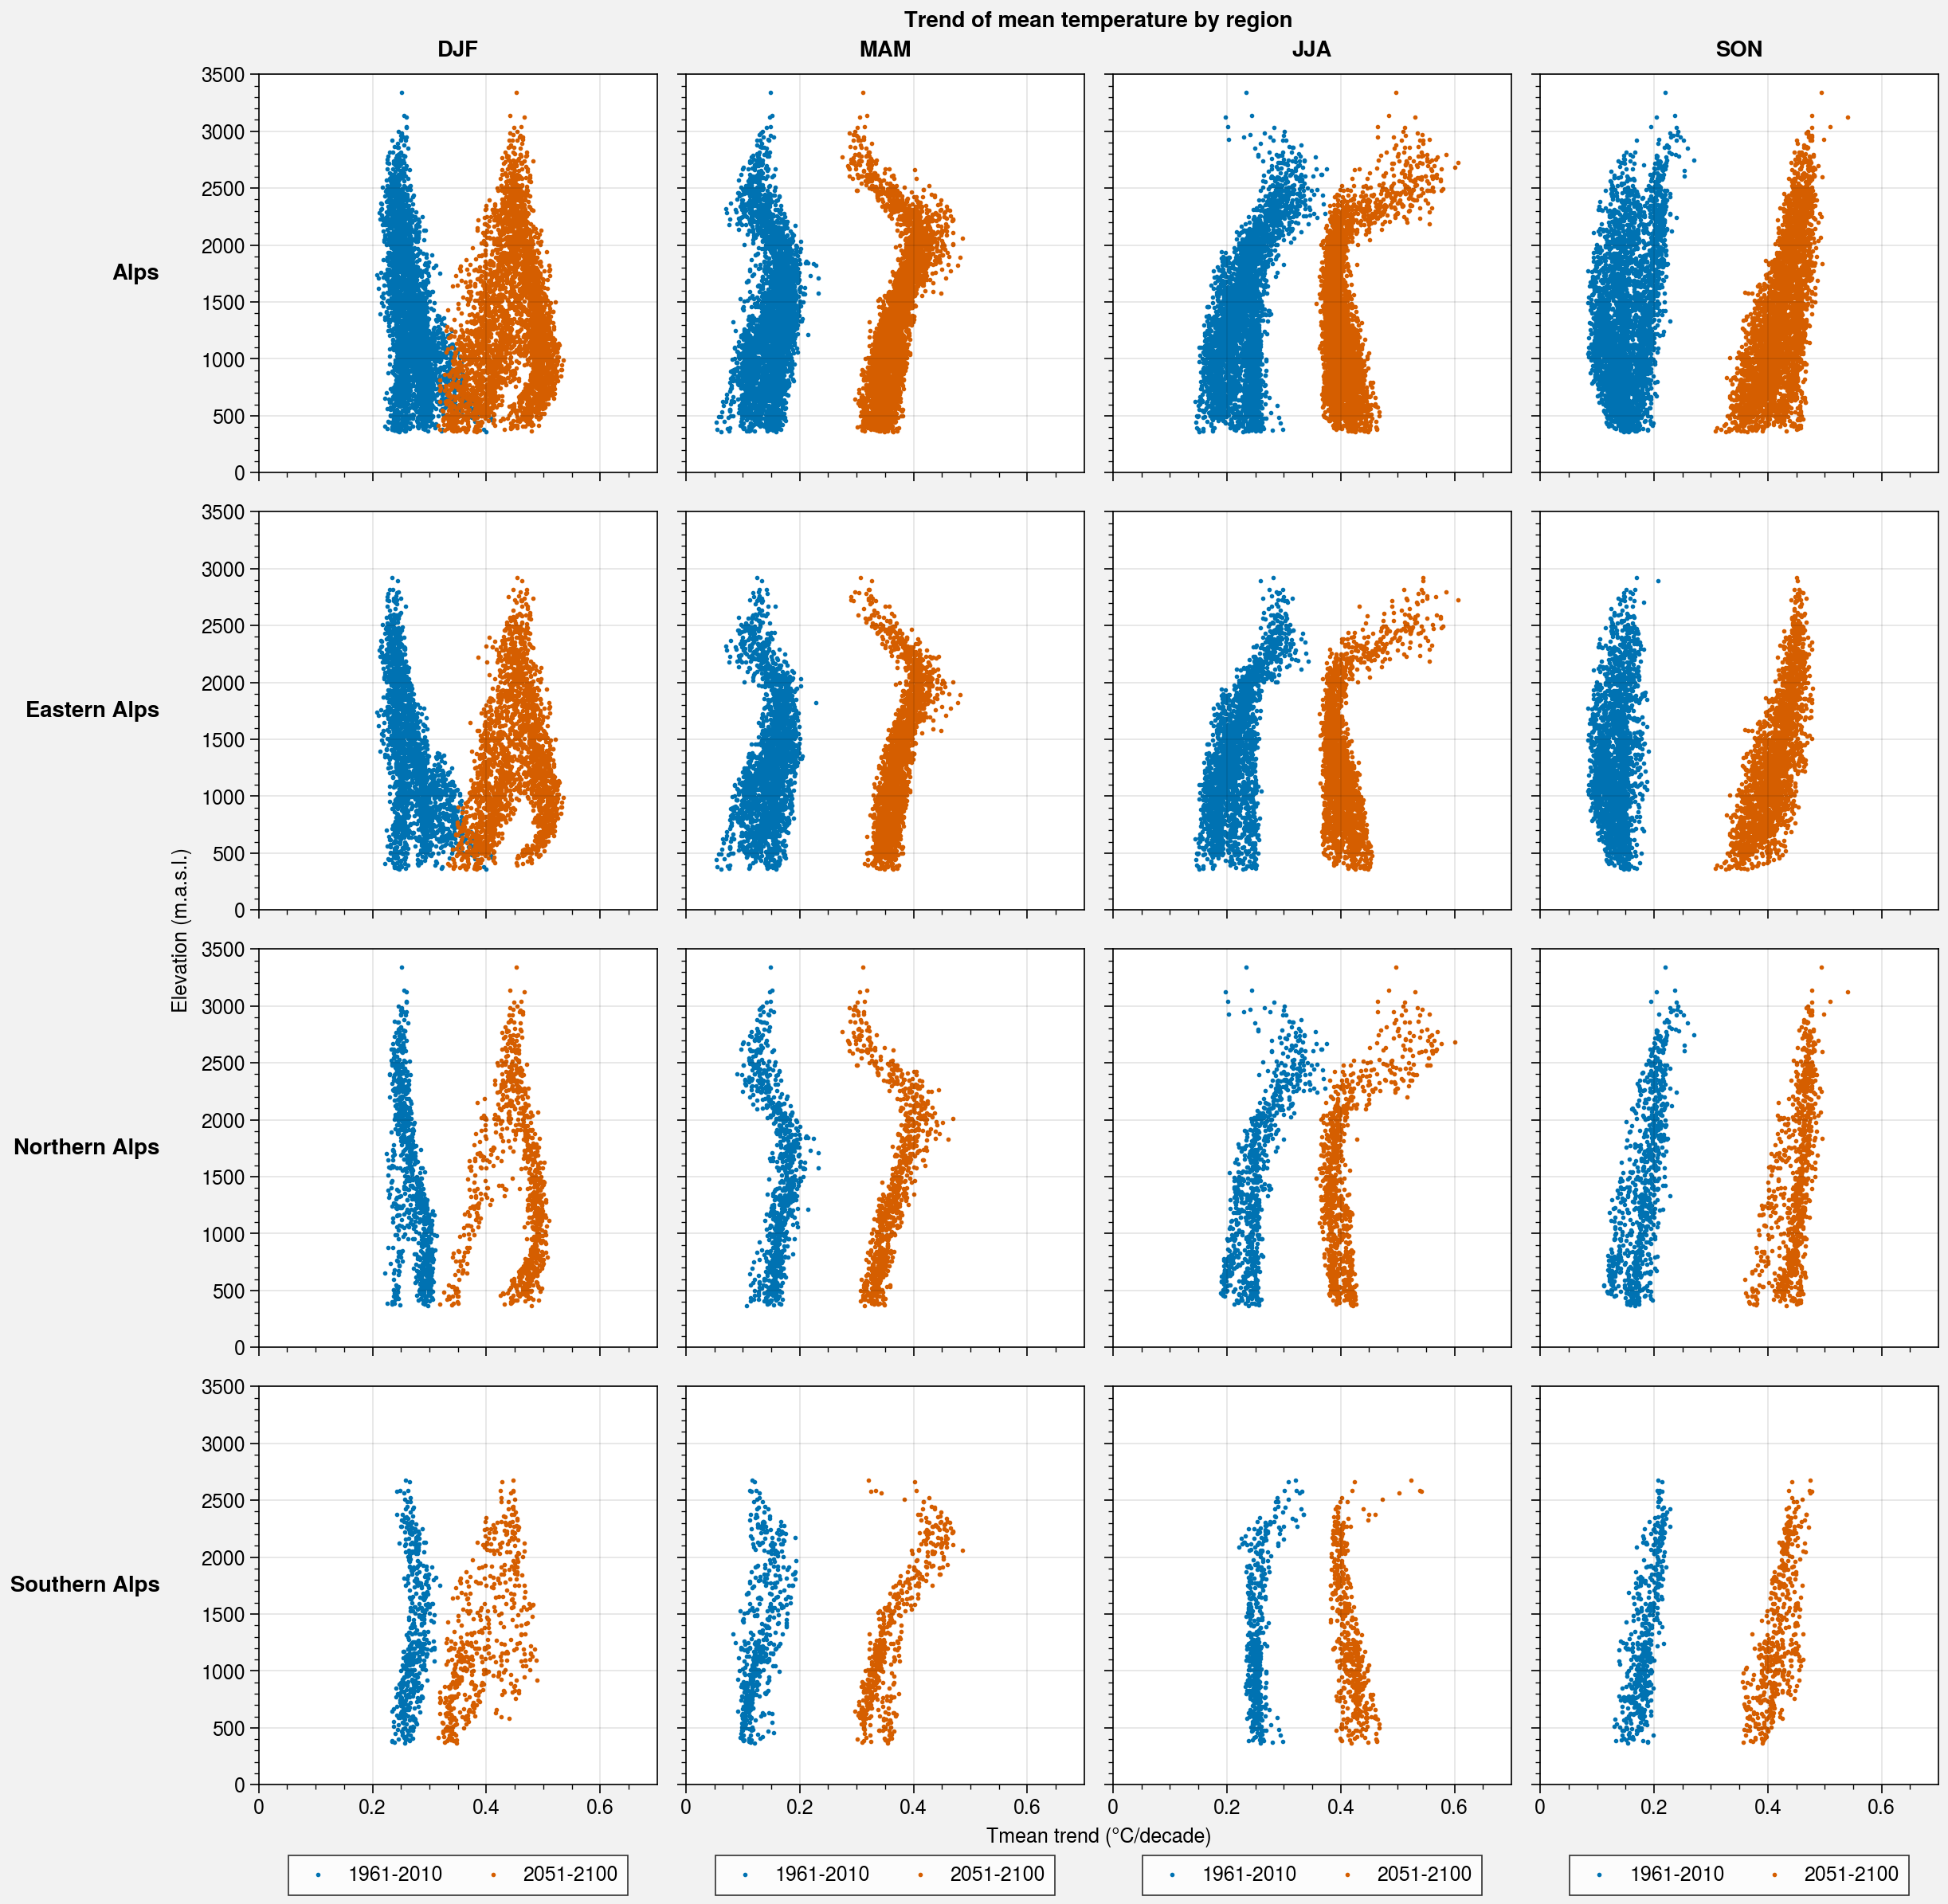

In [15]:
f, axs = pplt.subplots(ncols=4, nrows=4)
leg = ['1961-2010','2051-2100']

for i in range(4):
    slope_T_hist_alps = np.ma.masked_array(slope_T_periods_50[0,i], mask=np.invert(alps))
    slope_T_hist_east_alps = np.ma.masked_array(slope_T_periods_50[0,i], mask=np.invert(east_alps))
    slope_T_hist_north_alps = np.ma.masked_array(slope_T_periods_50[0,i], mask=np.invert(north_alps))
    slope_T_hist_south_alps = np.ma.masked_array(slope_T_periods_50[0,i], mask=np.invert(south_alps))
    slopes=[slope_T_hist_alps,slope_T_hist_east_alps,slope_T_hist_north_alps,slope_T_hist_south_alps]
    
    for j,slope in enumerate(slopes):
        ax = axs[i+4*j]
        blue_dot = ax.scatter(10*slope,ds.SH[jmin:jmax,imin:imax],s=2)
        
    
for i in range(4):
    slope_T_fut_alps = np.ma.masked_array(slope_T_periods_50[-1,i], mask=np.invert(alps))
    slope_T_fut_east_alps = np.ma.masked_array(slope_T_periods_50[-1,i], mask=np.invert(east_alps))
    slope_T_fut_north_alps = np.ma.masked_array(slope_T_periods_50[-1,i], mask=np.invert(north_alps))
    slope_T_fut_south_alps = np.ma.masked_array(slope_T_periods_50[-1,i], mask=np.invert(south_alps))
    slopes=[slope_T_fut_alps,slope_T_fut_east_alps,slope_T_fut_north_alps,slope_T_fut_south_alps]
    
    for j,slope in enumerate(slopes):
        ax = axs[i+4*j]
        orange_dot = ax.scatter(10*slope,ds.SH[jmin:jmax,imin:imax],s=2)
        ax.set_xlim((0.,0.7))
        ax.set_ylim((0.,3500))
        if(j==3):
            ax.legend([blue_dot,orange_dot],leg,loc='bottom')

axs.format(suptitle='Trend of mean temperature by region',collabels=['DJF','MAM','JJA', 'SON'],
           rowlabels=['Alps','Eastern Alps','Northern Alps','Southern Alps'],xlabel='Tmean trend (°C/decade)',ylabel='Elevation (m.a.s.l.)')

In [16]:

knot_numbers = 10
height_new = np.linspace(0, 1, knot_numbers+2)[1:-1]


height_max = np.full((4,90),np.nan) # 4 regions, 90 periods

alps_masks = [alps, east_alps, north_alps, south_alps]

for region in range(4):
    height = np.ma.masked_array(ds.SH[jmin:jmax,imin:imax], mask=np.invert(alps_masks[region]))
    vec_height = height[height.mask == False]
    for i in range(90):
        slope_T_MAM = 10*np.ma.masked_array(slope_T_periods_50[i,1], mask=np.invert(alps_masks[region]))
        vec_slope_T_MAM = slope_T_MAM[slope_T_MAM.mask == False]
        
        vec_height_srt = [y for (y,x) in sorted(zip(vec_height,vec_slope_T_MAM), key=lambda pair: pair[0])]
        vec_slope_T_MAM_srt = [x for (y,x) in sorted(zip(vec_height,vec_slope_T_MAM), key=lambda pair: pair[0])]
        
        q_knots = np.quantile(vec_height_srt, height_new)
        
        t,c,k = interpolate.splrep(vec_height_srt, vec_slope_T_MAM_srt, t=q_knots, s=1)
        yfit = interpolate.BSpline(t,c,k)(vec_height_srt)
        
        height_max[region,i] = vec_height_srt[np.argmax(yfit)]

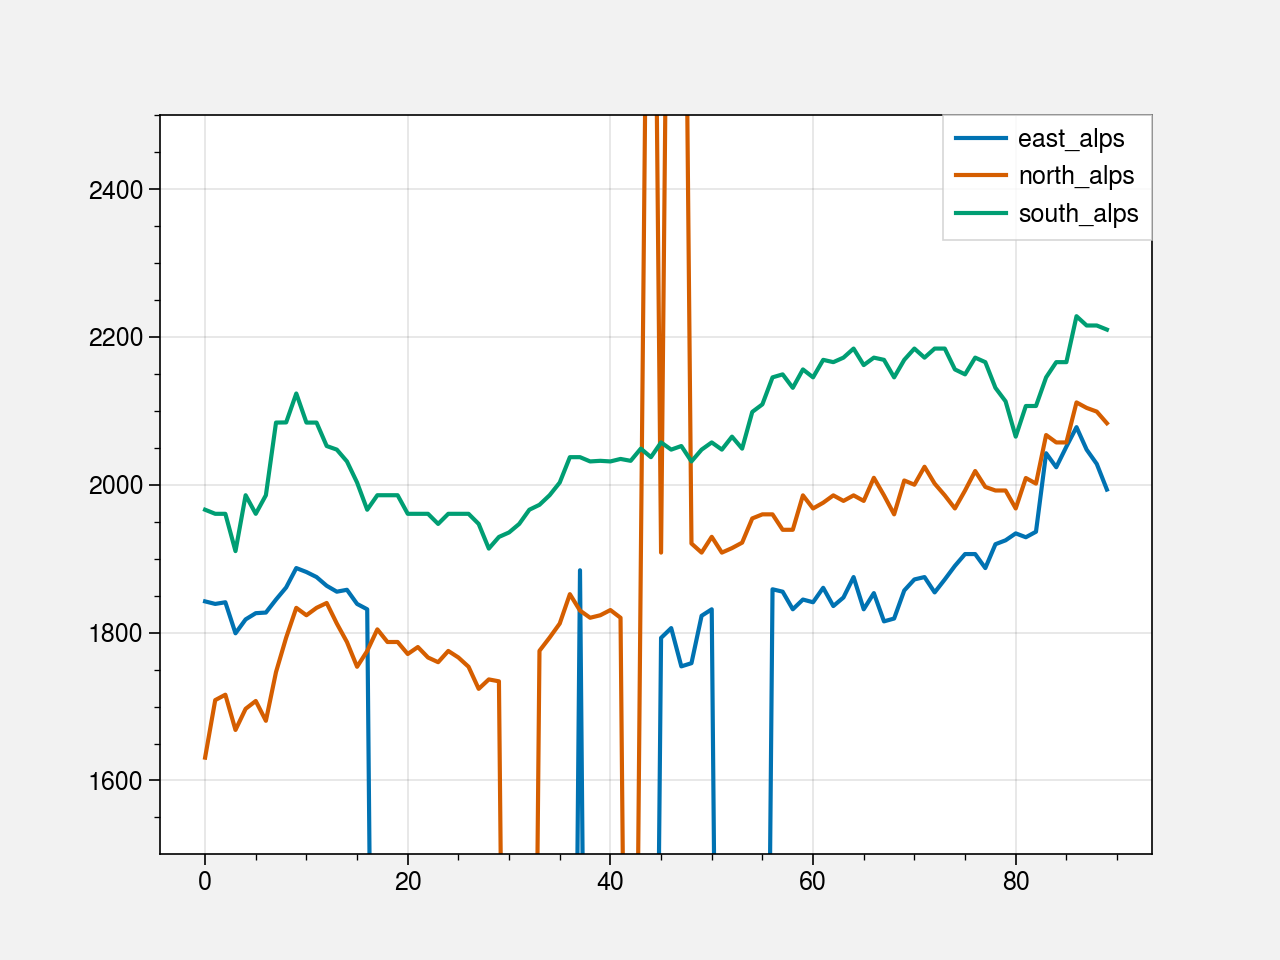

In [17]:
#plt.plot(height_max[0],label='alps')
plt.plot(height_max[1],label='east_alps')
plt.plot(height_max[2],label='north_alps')
plt.plot(height_max[3],label='south_alps')
plt.ylim(1500,2500)
plt.legend()

In [50]:

knot_numbers = 5
height_new = np.linspace(0, 1, knot_numbers+2)[1:-1]


height_max = np.full((4,90),np.nan) # 4 regions, 90 periods

alps_masks = [alps, east_alps, north_alps, south_alps]

for region in range(4):
    height = np.ma.masked_array(ds.SH[jmin:jmax,imin:imax], mask=np.invert(alps_masks[region]))
    vec_height = height[height.mask == False]
    for i in range(90):
        slope_T_MAM = 10*np.ma.masked_array(slope_T_periods_50[i,1], mask=np.invert(alps_masks[region]))
        vec_slope_T_MAM = slope_T_MAM[slope_T_MAM.mask == False]
        
        vec_height_srt = [y for (y,x) in sorted(zip(vec_height,vec_slope_T_MAM), key=lambda pair: pair[0])]
        vec_slope_T_MAM_srt = [x for (y,x) in sorted(zip(vec_height,vec_slope_T_MAM), key=lambda pair: pair[0])]
        
        q_knots = np.quantile(vec_height_srt, height_new)
        
        t,c,k = interpolate.splrep(vec_height_srt, vec_slope_T_MAM_srt, t=q_knots, s=1)
        yfit = interpolate.BSpline(t,c,k)(vec_height_srt)
        
        height_max[region,i] = vec_height_srt[np.argmax(yfit)]

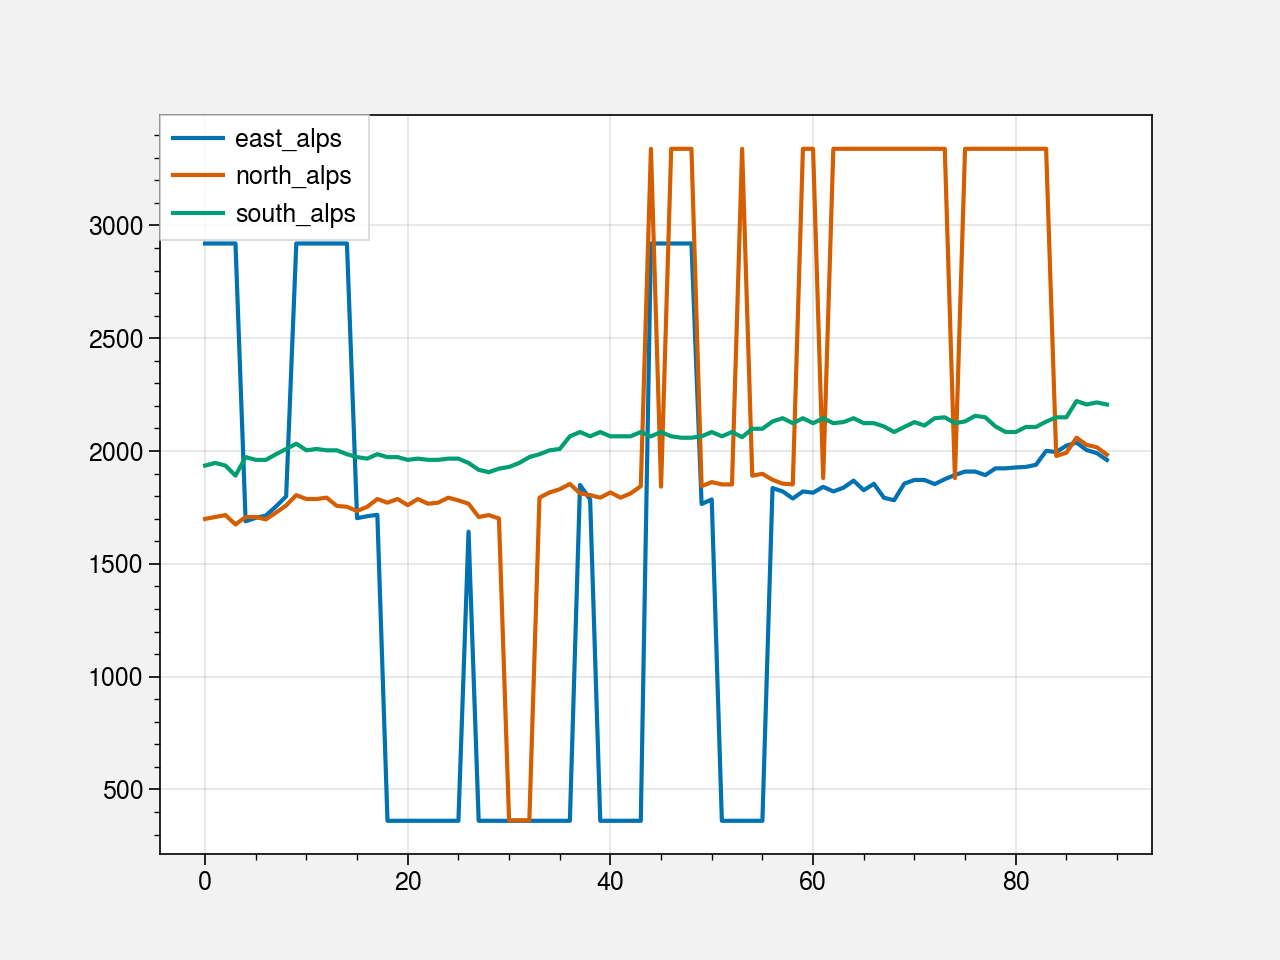

In [51]:
#plt.plot(height_max[0],label='alps')
plt.plot(height_max[1],label='east_alps')
plt.plot(height_max[2],label='north_alps')
plt.plot(height_max[3],label='south_alps')
plt.legend()

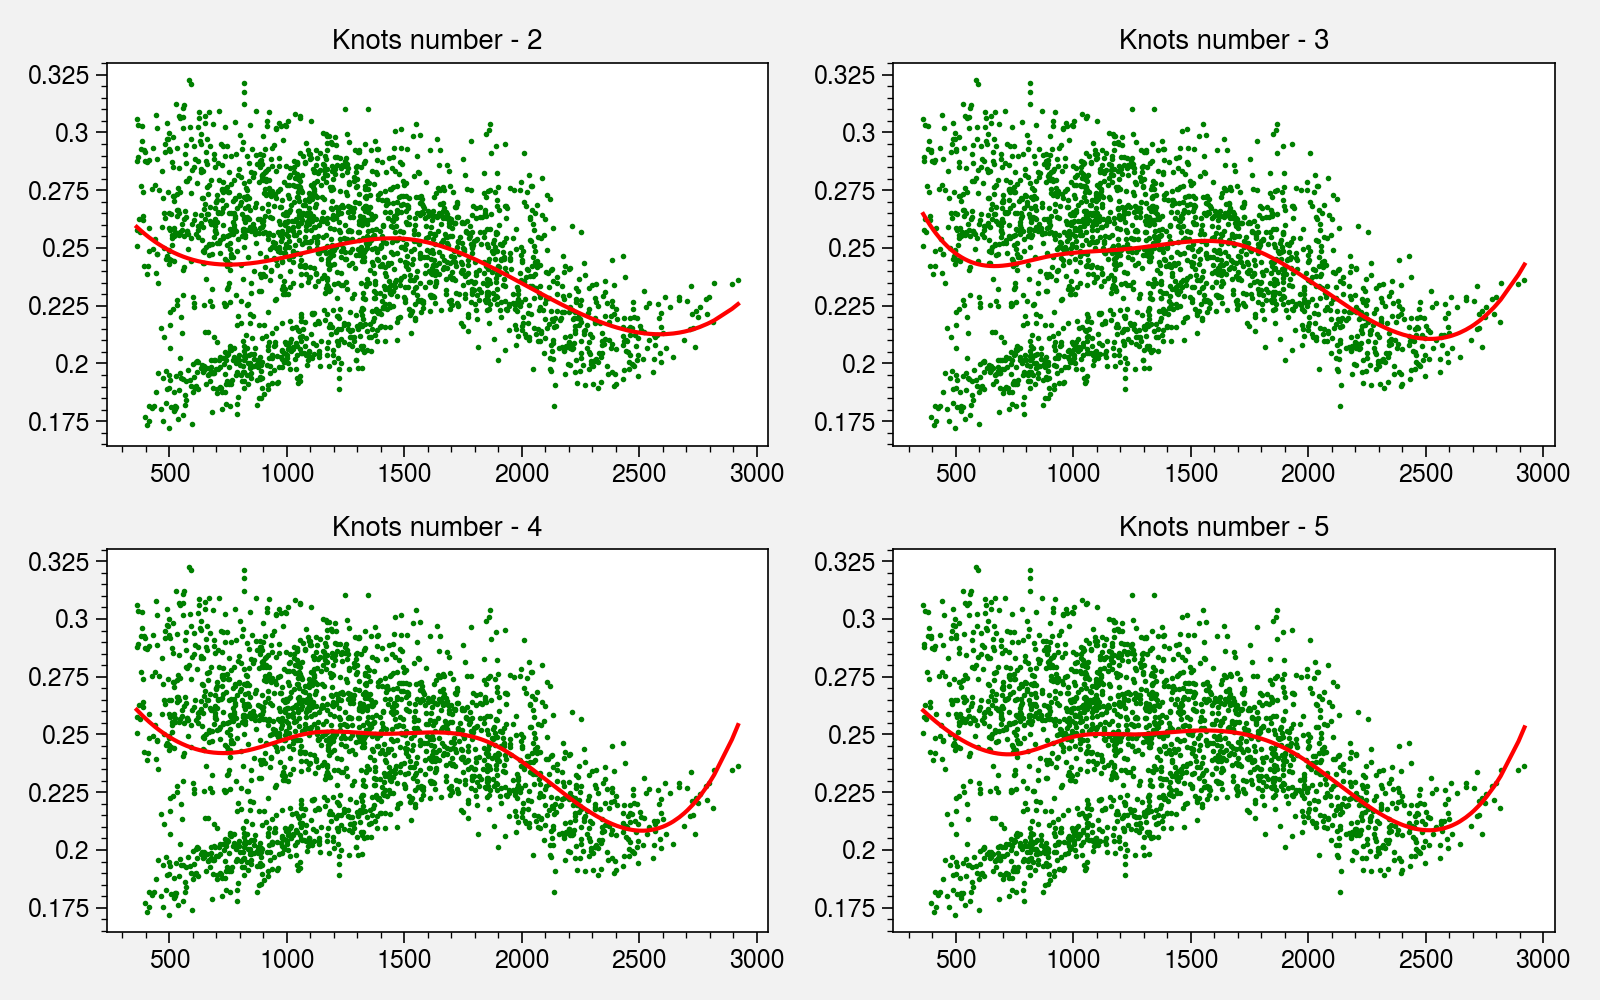

In [52]:
i=21

height = np.ma.masked_array(ds.SH[jmin:jmax,imin:imax], mask=np.invert(alps_masks[1]))
vec_height = height[height.mask == False]

slope_T_MAM = 10*np.ma.masked_array(slope_T_periods_50[i,1], mask=np.invert(alps_masks[1]))
vec_slope_T_MAM = slope_T_MAM[slope_T_MAM.mask == False]
        
vec_height_srt = [y for (y,x) in sorted(zip(vec_height,vec_slope_T_MAM), key=lambda pair: pair[0])]
vec_slope_T_MAM_srt = [x for (y,x) in sorted(zip(vec_height,vec_slope_T_MAM), key=lambda pair: pair[0])]


knots = [2, 3, 4, 5]
i = 0

ig, ax = plt.subplots(nrows=2, ncols=2, figsize=(8, 5))

for row in range(2):
    for col in range(2):
        ax[row][col].plot(vec_height_srt, vec_slope_T_MAM_srt, '.',c="g", markersize=2)
        yfit = spline(knots[i],vec_height_srt, vec_slope_T_MAM_srt)
        ax[row][col].plot(vec_height_srt, yfit, 'r')
        ax[row][col].set_title("Knots number - "+str(knots[i]))
        ax[row][col].grid()
        i=i+1
        
plt.tight_layout()        
plt.show()

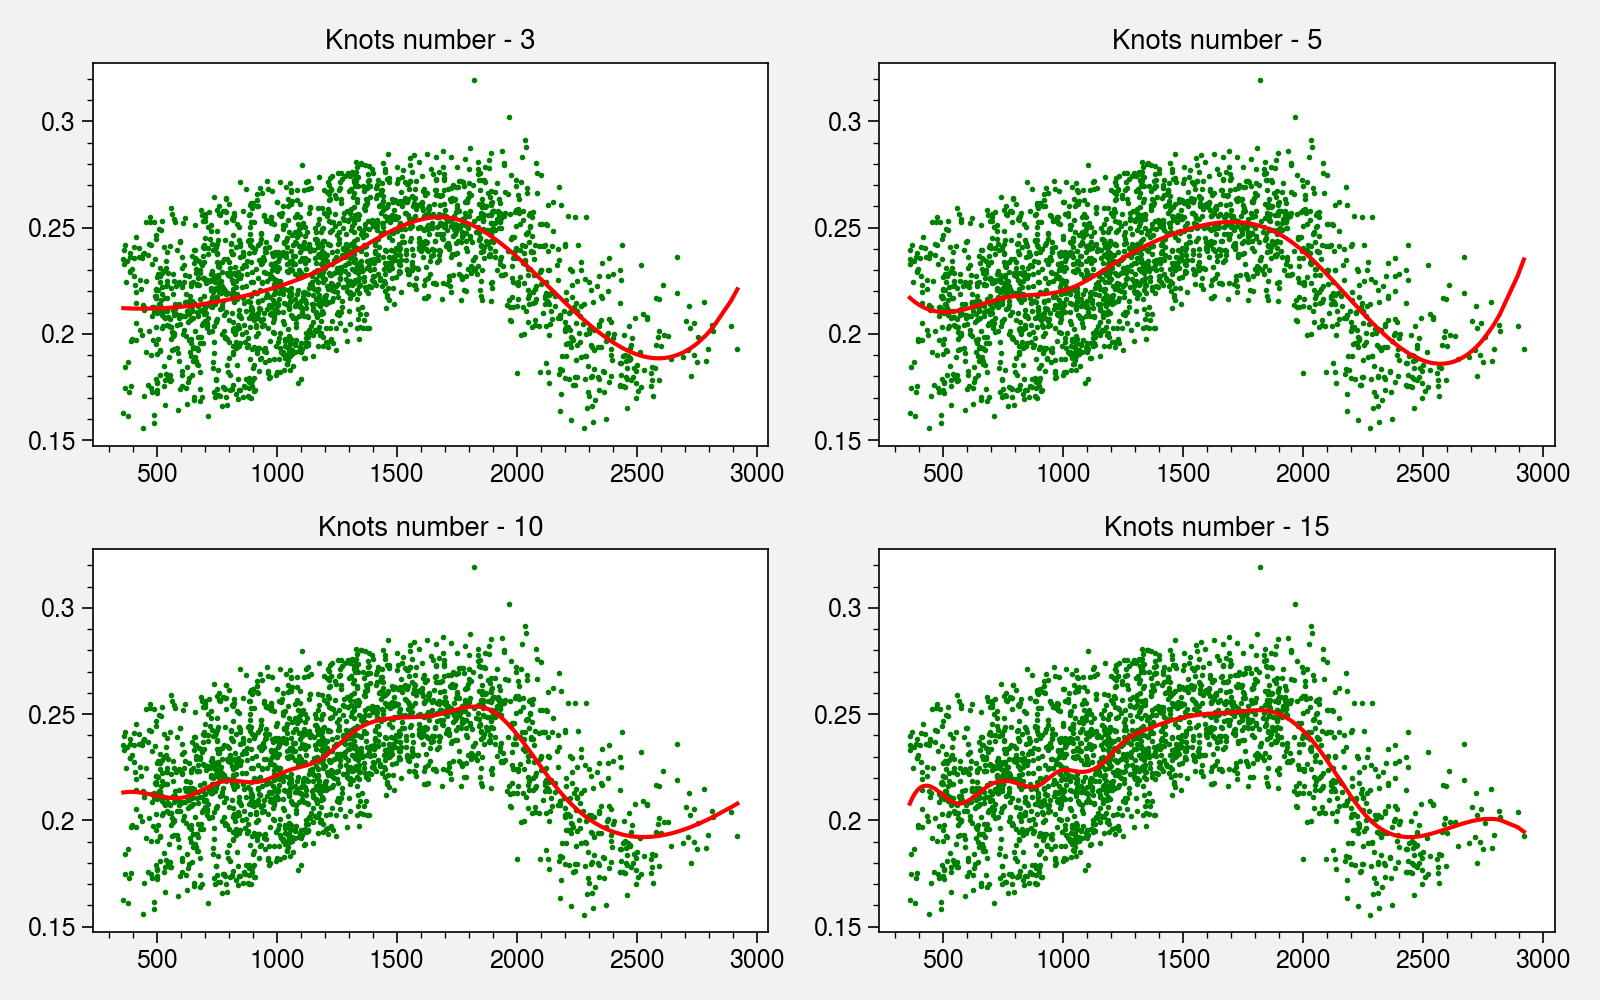

In [47]:
i=5

height = np.ma.masked_array(ds.SH[jmin:jmax,imin:imax], mask=np.invert(alps_masks[1]))
vec_height = height[height.mask == False]

slope_T_MAM = 10*np.ma.masked_array(slope_T_periods_50[i,1], mask=np.invert(alps_masks[1]))
vec_slope_T_MAM = slope_T_MAM[slope_T_MAM.mask == False]
        
vec_height_srt = [y for (y,x) in sorted(zip(vec_height,vec_slope_T_MAM), key=lambda pair: pair[0])]
vec_slope_T_MAM_srt = [x for (y,x) in sorted(zip(vec_height,vec_slope_T_MAM), key=lambda pair: pair[0])]


knots = [3, 5, 10, 15]
i = 0

ig, ax = plt.subplots(nrows=2, ncols=2, figsize=(8, 5))

for row in range(2):
    for col in range(2):
        ax[row][col].plot(vec_height_srt, vec_slope_T_MAM_srt, '.',c="g", markersize=2)
        yfit = spline(knots[i],vec_height_srt, vec_slope_T_MAM_srt)
        ax[row][col].plot(vec_height_srt, yfit, 'r')
        ax[row][col].set_title("Knots number - "+str(knots[i]))
        ax[row][col].grid()
        i=i+1
        
plt.tight_layout()        
plt.show()

In [ ]:
f, axs = pplt.subplots(proj='cyl', ncols=2, nrows=2, axwidth=8)

m=axs[0].pcolormesh(lon, lat, 10*slope_T_fut[0,:,:], levels=33,cmap='Reds')
f.colorbar(m,label= '°C/dec')
axs[0].contour(lon, lat,east_alps)
axs[0].contour(lon, lat,north_alps)
axs[0].contour(lon, lat,south_alps)
axs[0].format(**normal_format,title='DJF')
axs[0].format(ocean=True,oceancolor='lightgray',reso='hi')#, latlim=[40.,51.],lonlim=[0.,20.])

m=axs[1].pcolormesh(lon, lat, 10*slope_T_fut[1,:,:], levels=33,cmap='Reds')
axs[1].contour(lon, lat,east_alps)
axs[1].contour(lon, lat,north_alps)
axs[1].contour(lon, lat,south_alps)
axs[1].format(**normal_format,title='MAM')
axs[1].format(ocean=True,oceancolor='lightgray',reso='hi')#, latlim=[40.,51.],lonlim=[0.,20.])


m=axs[2].pcolormesh(lon, lat, 10*slope_T_fut[2,:,:], levels=33,cmap='Reds')
axs[2].contour(lon, lat,east_alps)
axs[2].contour(lon, lat,north_alps)
axs[2].contour(lon, lat,south_alps)
axs[2].format(**normal_format,title='JJA')
axs[2].format(ocean=True,oceancolor='lightgray',reso='hi')#, latlim=[40.,51.],lonlim=[0.,20.])

m=axs[3].pcolormesh(lon, lat, 10*slope_T_fut[3,:,:], levels=33,cmap='Reds')
axs[3].contour(lon, lat,east_alps)
axs[3].contour(lon, lat,north_alps)
axs[3].contour(lon, lat,south_alps)
axs[3].format(**normal_format,title='SON')
axs[3].format(ocean=True,oceancolor='lightgray',reso='hi')#, latlim=[40.,51.],lonlim=[0.,20.])